<a href="https://colab.research.google.com/github/JCalskr/hello-world/blob/main/FinalProject_JCalderon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Geospatial Analysis with Python and R (LTOM.02.041)**

## **Final Project Assignment**
Jorge Alberto Calderon Enamorado

This study focuses on the classification of average precipitation during the rainy (December to May) and dry (June to November) seasons for the year 2020 in the Amazon River basins. For this purpose, rasters provided by WorldClim will be used. Information on the Amazon River was obtained from NASA-LBA-ECO CD-06 Amazon River Basin Land and Stream Drainage Direction Maps, watershed boundaries were acquired from HydroBASINS, while country boundaries were sourced by Natural Earth. In addition, the calculation of zonal raster statistics will be carried out to compare data between seasons.

## **Problem 1: Spatial analysis and visualize a static map with multiple layers on it (10 points)**

# Library *Imports & Install*

In [1]:
!pip install wget
!pip install mapclassify
!pip install rasterstats
!pip install rioxarray
!pip install rasterio

import wget
import pooch
import geopandas as gpd
import pandas as pd

import zipfile
import os
import glob
import re

import rasterio
from rasterio.merge import merge
from rasterio.enums import Resampling
from rasterio import mask

import rioxarray as rxr

from rasterstats import zonal_stats

import mapclassify as mc
from mapclassify import Quantiles

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np

import collections

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=a9594705d98ffbf8e60e9e95b70439454950d821c113245191404f7472b73947
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.4 MB/s eta 0:00:00


# Retrieve the Data

*   Amazon River (source: NASA-LBA-ECO CD-06 Amazon River Basin Land and Stream Drainage Direction Maps)



In [2]:
url1= "https://raw.githubusercontent.com/JCald12/geopython/145e9127d084f448d73b5b867c2c34a43cb089b2/amazon_jogi.gpkg"
output_file1 = "amazon_jogi.gpkg"

wget.download(url1, output_file1)

'amazon_jogi.gpkg'

*   Amazon Basins  (source: HydroBASINS)

In [3]:
!wget https://data.hydrosheds.org/file/hydrobasins/standard/hybas_sa_lev01-12_v1c.zip

--2024-01-13 00:18:55--  https://data.hydrosheds.org/file/hydrobasins/standard/hybas_sa_lev01-12_v1c.zip
Resolving data.hydrosheds.org (data.hydrosheds.org)... 104.21.14.61, 172.67.158.28, 2606:4700:3036::6815:e3d, ...
Connecting to data.hydrosheds.org (data.hydrosheds.org)|104.21.14.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 334160720 (319M) [application/zip]
Saving to: ‘hybas_sa_lev01-12_v1c.zip’

hybas_sa_lev01-12_v 100%[===================>] 318.68M  17.9MB/s    in 21s     

2024-01-13 00:19:17 (15.3 MB/s) - ‘hybas_sa_lev01-12_v1c.zip’ saved [334160720/334160720]



*   Countries (source: Natural Earth)

In [4]:
natural_earth_extracted_file = pooch.retrieve(
    url="https://raw.githubusercontent.com/LandscapeGeoinformatics/geopy-2023/main/files/data/T2/extracted_natural_earth.gpkg",
    known_hash="md5:d79a99f06a7bfb2a859d5f9a421d63b9"
)



*   Precipitation Raster (source: WorldClim Precipitation)



In [5]:
!wget https://geodata.ucdavis.edu/climate/worldclim/2_1/hist/cts4.06/10m/wc2.1_cruts4.06_10m_prec_2020-2021.zip

--2024-01-13 00:19:18--  https://geodata.ucdavis.edu/climate/worldclim/2_1/hist/cts4.06/10m/wc2.1_cruts4.06_10m_prec_2020-2021.zip
Resolving geodata.ucdavis.edu (geodata.ucdavis.edu)... 128.120.146.30
Connecting to geodata.ucdavis.edu (geodata.ucdavis.edu)|128.120.146.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43596808 (42M) [application/zip]
Saving to: ‘wc2.1_cruts4.06_10m_prec_2020-2021.zip’

wc2.1_cruts4.06_10m 100%[===================>]  41.58M  27.5MB/s    in 1.5s    

2024-01-13 00:19:20 (27.5 MB/s) - ‘wc2.1_cruts4.06_10m_prec_2020-2021.zip’ saved [43596808/43596808]



# Prepare Vector Data for Analysis

## River and Streams

*   Amazon River

In [6]:
amazon_jogi = gpd.read_file("amazon_jogi.gpkg")
amazon_jogi.head()

,LENGTH,AMZSTRMORD,AMZSTRMO_1,geometry
0,0.026213,1,3,"MULTILINESTRING ((-59.86750 5.24750, -59.86750..."
1,0.005000,2,3,"MULTILINESTRING ((-59.87750 5.22750, -59.88250..."
2,0.195563,3,4,"MULTILINESTRING ((-59.88250 5.22750, -59.88750..."
3,0.005000,4,3,"MULTILINESTRING ((-59.95250 5.09250, -59.95750..."
4,0.024142,5,4,"MULTILINESTRING ((-59.95750 5.09250, -59.96250..."


*   Select only streams from 7 to 10 of the Strahler Order

In [7]:
amazonjogi = amazon_jogi.loc[amazon_jogi['AMZSTRMO_1'].between(7, 10)]
amazonjogi

,LENGTH,AMZSTRMORD,AMZSTRMO_1,geometry
321,0.129853,322,7,"MULTILINESTRING ((-61.66750 3.53250, -61.66250..."
361,0.039142,362,7,"MULTILINESTRING ((-60.94750 3.45750, -60.94250..."
364,0.014142,365,7,"MULTILINESTRING ((-60.95750 3.44750, -60.95250..."
365,0.270711,366,7,"MULTILINESTRING ((-60.91250 3.45750, -60.90750..."
373,0.328640,374,7,"MULTILINESTRING ((-61.26750 3.40250, -61.26250..."
...,...,...,...,...
33652,0.087426,33653,7,"MULTILINESTRING ((-63.55750 -19.08750, -63.557..."
33654,0.117426,33655,7,"MULTILINESTRING ((-63.66250 -19.08750, -63.657..."
33663,0.152426,33664,7,"MULTILINESTRING ((-63.92250 -19.17250, -63.922..."
33664,0.234350,33665,7,"MULTILINESTRING ((-64.10250 -18.98250, -64.097..."


## Basins

*   Extract files from ZIP

In [8]:
hydrobasinszip = "hybas_sa_lev01-12_v1c.zip"

extract_basin = "hydrobasins"

os.makedirs(extract_basin, exist_ok=True)

with zipfile.ZipFile(hydrobasinszip, 'r') as zip_ref:
    zip_ref.extractall(extract_basin)

extracted_files = os.listdir(extract_basin)
os.remove(hydrobasinszip)

*   Select only level 5 basins, deleting everything else.

In [9]:
selectedhydro = glob.glob(os.path.join(extract_basin, '*.shp'))


deleteremaining_hydro = [file for file in selectedhydro if 'lev05_v1c' not in file]

for deletebasins in deleteremaining_hydro:
    try:

        os.remove(deletebasins)
        print(f"Deleted: {deletebasins}")

        file_prefix = os.path.splitext(deletebasins)[0]
        delete_ext = ['.dbf', '.prj', '.sbn', '.sbx', '.shx','.shp.xml']

        for extension in delete_ext:
            associated_file = file_prefix + extension

            try:
                os.remove(associated_file)
                print(f"Deleted: {associated_file}")
            except OSError as e:
                print(f"Error deleting {associated_file}: {e}")

    except OSError as e:
        print(f"Error deleting {deletebasins}: {e}")

Deleted: hydrobasins/hybas_sa_lev11_v1c.shp
Deleted: hydrobasins/hybas_sa_lev11_v1c.dbf
Deleted: hydrobasins/hybas_sa_lev11_v1c.prj
Deleted: hydrobasins/hybas_sa_lev11_v1c.sbn
Deleted: hydrobasins/hybas_sa_lev11_v1c.sbx
Deleted: hydrobasins/hybas_sa_lev11_v1c.shx
Deleted: hydrobasins/hybas_sa_lev11_v1c.shp.xml
Deleted: hydrobasins/hybas_sa_lev12_v1c.shp
Deleted: hydrobasins/hybas_sa_lev12_v1c.dbf
Deleted: hydrobasins/hybas_sa_lev12_v1c.prj
Deleted: hydrobasins/hybas_sa_lev12_v1c.sbn
Deleted: hydrobasins/hybas_sa_lev12_v1c.sbx
Deleted: hydrobasins/hybas_sa_lev12_v1c.shx
Deleted: hydrobasins/hybas_sa_lev12_v1c.shp.xml
Deleted: hydrobasins/hybas_sa_lev08_v1c.shp
Deleted: hydrobasins/hybas_sa_lev08_v1c.dbf
Deleted: hydrobasins/hybas_sa_lev08_v1c.prj
Deleted: hydrobasins/hybas_sa_lev08_v1c.sbn
Deleted: hydrobasins/hybas_sa_lev08_v1c.sbx
Deleted: hydrobasins/hybas_sa_lev08_v1c.shx
Deleted: hydrobasins/hybas_sa_lev08_v1c.shp.xml
Deleted: hydrobasins/hybas_sa_lev10_v1c.shp
Deleted: hydrobasins

In [10]:
selectedhydro_amazon = [file for file in selectedhydro if 'hybas_sa_lev05_v1c' in file]

In [11]:
amazon_vesikond = gpd.read_file(selectedhydro_amazon[0])

In [12]:
amazon_vesikond.head()

,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry
0,6050000010,0,6050000010,6050000010,0.0,0.0,72363.7,72363.7,61100,0,1,0,1,"MULTIPOLYGON (((-75.73472 10.17083, -75.75746 ..."
1,6050000740,0,6050000740,6050000740,0.0,0.0,17944.3,260739.0,61201,0,0,1,2,"POLYGON ((-74.07500 9.59167, -74.07254 9.59131..."
2,6050068100,6050000740,6050000740,6050000740,276.9,276.9,17105.5,17105.5,61202,0,0,2,3,"POLYGON ((-74.95833 8.13750, -74.95777 8.12279..."
3,6050068110,6050000740,6050000740,6050000740,277.1,277.1,610.1,225687.7,61203,0,0,1,4,"POLYGON ((-74.64167 9.04583, -74.63953 9.04519..."
4,6050070260,6050068110,6050000740,6050000740,315.1,315.1,61901.9,61901.9,61204,0,0,2,5,"MULTIPOLYGON (((-74.75417 7.02083, -74.75295 7..."


*   Clean the data for Basins

In [13]:
vesikondcolumns = ['MAIN_BAS','ORDER','SORT', 'geometry']
amazon_vesikond = amazon_vesikond[vesikondcolumns]

## Countries

In [14]:
riigid = gpd.read_file(natural_earth_extracted_file, layer="ne_50m_admin_0_countries", driver="GPKG")

*   Clean the data for Countries

In [15]:
countriescolumns = ['CONTINENT', 'NAME','POP_EST','GDP_MD', 'geometry']
riigid = riigid[countriescolumns]

### Set EPSG to 31970 (SIRGAS 2000 / UTM zone 16N)

In [16]:
riigid = riigid.to_crs(epsg=31970)
amazonjogi = amazonjogi.to_crs(epsg=31970)
amazon_vesikond = amazon_vesikond.to_crs(epsg=31970)
amazon_vesikond = amazon_vesikond.dropna()
amazonjogi.reset_index(drop=True, inplace=True)
amazonjogi, riigid = amazonjogi.align(riigid, axis=1)

# Prepare Raster Data for Analysis

*   Extract files from ZIP

In [17]:
worldclimprep = "wc2.1_cruts4.06_10m_prec_2020-2021.zip"

extract_dir = "worldclim_data"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(worldclimprep, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

extracted_files = os.listdir(extract_dir)
os.remove(worldclimprep)

*   Filter 2020 images and delete the rest.

In [18]:
worlddata_dir = "worldclim_data"

tif_files = glob.glob(os.path.join(worlddata_dir, '*.tif'))

tif_delete = [file for file in tif_files if '2020' not in file]

for worldclim_delete in tif_delete:
    try:

        os.remove(worldclim_delete)
        print(f"Deleted: {worldclim_delete}")

    except OSError as e:
        print(f"Error deleting {worldclim_delete}: {e}")

Deleted: worldclim_data/wc2.1_10m_prec_2021-10.tif
Deleted: worldclim_data/wc2.1_10m_prec_2021-03.tif
Deleted: worldclim_data/wc2.1_10m_prec_2021-11.tif
Deleted: worldclim_data/wc2.1_10m_prec_2021-01.tif
Deleted: worldclim_data/wc2.1_10m_prec_2021-12.tif
Deleted: worldclim_data/wc2.1_10m_prec_2021-02.tif
Deleted: worldclim_data/wc2.1_10m_prec_2021-04.tif
Deleted: worldclim_data/wc2.1_10m_prec_2021-09.tif
Deleted: worldclim_data/wc2.1_10m_prec_2021-07.tif
Deleted: worldclim_data/wc2.1_10m_prec_2021-08.tif
Deleted: worldclim_data/wc2.1_10m_prec_2021-06.tif
Deleted: worldclim_data/wc2.1_10m_prec_2021-05.tif


In [19]:
tif_files_2020 = [file for file in tif_files if '2020' in file]

*   Define months for rainy and dry seasons

In [20]:
rainy_months= ['12', '01', '02', '03', '04', '05']
dry_months = ['06', '07', '08', '09','10', '11']

*   Filter files for rainy and dry seasons

In [21]:
rainymonth_pattern = r"-({})\.tif$".format('|'.join(rainy_months))
drymonth_pattern = r"-({})\.tif$".format('|'.join(dry_months))

rainy_season_files = [file for file in tif_files_2020 if re.search(rainymonth_pattern, file)]
dry_season_files = [file for file in tif_files_2020 if re.search(drymonth_pattern, file)]

*   Merge files for rainy and dry seasons

In [22]:
def merge_season(files, output_path):
    sources = [rasterio.open(file) for file in files]
    merged, out_transform = merge(sources, resampling=Resampling.bilinear)
    with rasterio.open(output_path, "w", **sources[0].meta) as dest:
        dest.write(merged)

merged_rainy_path = "merged_rainy_season.tif"
merge_season(rainy_season_files, merged_rainy_path)

merged_dry_path = "merged_dry_season.tif"
merge_season(dry_season_files, merged_dry_path)

*   Reproject to EPSG:31970 and save to GeoTIFF

In [23]:
rainy = rxr.open_rasterio("merged_rainy_season.tif")
dry    = rxr.open_rasterio("merged_dry_season.tif")

In [24]:
rainy_reprojected = rainy.rio.reproject("EPSG:31970")
dry_reprojected    = dry.rio.reproject("EPSG:31970")

In [25]:
rainy_reprojected.rio.to_raster("reprojected_rainy_season.tif")
dry_reprojected.rio.to_raster("reprojected_dry_season.tif")

# Task 1. Select the countries which the Amazon River passes through, and their respective basins.

*   Generate a 50 km Buffer for the Amazon River

In [26]:
amazonjogibuff = amazonjogi.buffer(10000)

*    Extract the countries using *Intersect*



In [27]:
amazonjogiriigid = riigid[riigid.intersects(amazonjogibuff.unary_union)]

*    Extract the basins using *Intersect*

In [28]:
amazonvesikondiriigid = amazon_vesikond[amazon_vesikond.intersects(amazonjogibuff.unary_union)]

*    Overlay the basins with countries

In [29]:
vesikond_riigid = gpd.overlay(amazonvesikondiriigid, amazonjogiriigid[['geometry', 'NAME']], how='identity',)
vesikond_riigid

vesikond_riigid = vesikond_riigid.dropna(subset=['NAME'])

<ipython-input-29-1ab66509932f>:1: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  vesikond_riigid = gpd.overlay(amazonvesikondiriigid, amazonjogiriigid[['geometry', 'NAME']], how='identity',)


**TASK 1. RESULTS**

In [30]:
print(f"The Amazon River (streams in Strahler Order 7-10) passes through {len(amazonjogiriigid)} countries, which are: {', '.join(amazonjogiriigid['NAME'].to_list())}; consisting of {len(amazonvesikondiriigid)} basins.")

The Amazon River (streams in Strahler Order 7-10) passes through 6 countries, which are: Venezuela, Peru, Ecuador, Colombia, Brazil, Bolivia; consisting of 71 basins.


# Task 2. Calculate Zonal Raster Statictics

In [31]:
reprojected_rainy = "reprojected_rainy_season.tif"
reprojected_dry = "reprojected_dry_season.tif"

*    Clip Seasonal Precipitation Raster to Amazon Basins Boundary

In [32]:
reprojected_rainy = "reprojected_rainy_season.tif"
reprojected_dry =  "reprojected_dry_season.tif"

def clipraster(input_raster, output_path, geometry):
    with rasterio.open(input_raster, "r") as src:
        out_image, out_transform = mask.mask(src, geometry, crop=True)
        out_meta = src.meta.copy()

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(out_image)

*    Save raster files

In [33]:
clipraster(reprojected_dry, "amazon_dry_season.tif", amazonvesikondiriigid.geometry)
clipraster(reprojected_rainy, "amazon_rainy_season.tif", amazonvesikondiriigid.geometry)

*   Raster Zonal Statistics

In [34]:
rainyzs = zonal_stats(amazonvesikondiriigid, 'amazon_rainy_season.tif', stats=['mean','sum', 'min', 'max','std', 'range'])
dryzs = zonal_stats(amazonvesikondiriigid, 'amazon_dry_season.tif', stats=['mean','sum', 'min', 'max','std', 'range'])

*   For Rainy Season

In [35]:
rainy_stats = pd.DataFrame(rainyzs)

rainy_stats.rename(columns={'mean':'prep_mean',
                              'sum':'prep_sum',
                              'min':'prep_min',
                              'max':'prep_max',
                              'std':'prep_std',
                              'range':'prep_range'}, inplace=True)

amazonvesikondiriigid = amazonvesikondiriigid.reset_index(drop=True)
rainy_stats = rainy_stats.reset_index(drop=True)

rainy_data = pd.concat([amazonvesikondiriigid, rainy_stats], axis=1)

*   For Dry Season

In [36]:
dry_stats = pd.DataFrame(dryzs)

dry_stats.rename(columns={'mean':'prep_mean',
                          'sum':'prep_sum',
                          'min':'prep_min',
                          'max':'prep_max',
                          'std':'prep_std',
                          'range':'prep_range'}, inplace=True)

amazonvesikondiriigid = amazonvesikondiriigid.reset_index(drop=True)
dry_stats = dry_stats.reset_index(drop=True)

dry_data = pd.concat([amazonvesikondiriigid, dry_stats], axis=1)


*   Calculate areas for basins

In [37]:
dry_data['Area_m2'] = dry_data['geometry'].area
dry_data['Area_km2'] = dry_data['Area_m2'] / 1e6

rainy_data['Area_m2'] = rainy_data['geometry'].area
rainy_data['Area_km2'] = rainy_data['Area_m2'] / 1e6

*   Calculate Average Precipitation/km2

In [38]:
rainy_data['average_precip_km2'] = rainy_data['prep_sum']/rainy_data['Area_km2']

dry_data['average_precip_km2'] = dry_data['prep_sum']/dry_data['Area_km2']

*   Comparison of Metrics



In [39]:
# Compare Mean Precipitation
mean_comparison = pd.DataFrame({
    'Season': ['Rainy', 'Dry'],
    'Mean Precipitation': [rainy_stats['prep_mean'].mean(), dry_stats['prep_mean'].mean()]
})

# Compare Total Precipitation
total_precipitation_comparison = pd.DataFrame({
    'Season': ['Rainy', 'Dry'],
    'Total Precipitation': [rainy_stats['prep_sum'].sum(), dry_stats['prep_sum'].sum()]
})

# Compare Variability (Standard Deviation)
variability_comparison = pd.DataFrame({
    'Season': ['Rainy', 'Dry'],
    'Variability (Std Dev)': [rainy_stats['prep_std'].mean(), dry_stats['prep_std'].mean()]
})

# Compare Extreme Events (Min and Max)
extreme_events_comparison = pd.DataFrame({
    'Season': ['Rainy', 'Dry'],
    'Min Precipitation': [rainy_stats['prep_min'].min(), dry_stats['prep_min'].min()],
    'Max Precipitation': [rainy_stats['prep_max'].max(), dry_stats['prep_max'].max()]
})

# Compare Range of Precipitation
range_comparison = pd.DataFrame({
    'Season': ['Rainy', 'Dry'],
    'Range': [rainy_stats['prep_range'].mean(), dry_stats['prep_range'].mean()]
})

max_dry_basin = dry_data.loc[dry_data['average_precip_km2'].idxmax()]
max_rainy_basin = rainy_data.loc[rainy_data['average_precip_km2'].idxmax()]

**TASK 2. RESULTS**

In [40]:
print("\033[1m\nBasin with the Most Precipitation in Dry Season:\033[0m")
print("- Basin ID:", max_dry_basin['SORT'])
print("- Country:",vesikond_riigid.loc[vesikond_riigid['SORT'] == max_dry_basin['SORT'], 'NAME'].values[0])
print("- Maximum Precipitation (mm/Sq. km):", round(max_dry_basin['average_precip_km2'], 2))


print("\033[1m\nBasin with the Most Precipitation in Rainy Season:\033[0m")
print("- Basin ID:", max_rainy_basin['SORT'])
print("- Country:",vesikond_riigid.loc[vesikond_riigid['SORT'] == max_rainy_basin['SORT'], 'NAME'].values[0])
print("- Maximum Precipitation (mm/Sq. km):", round(max_rainy_basin['average_precip_km2'], 2))

print("\033[1m\nComparative Precipitation Metrics:\033[0m")
def print_comparison(comparison_df, metric_name):
    print(f"\n{metric_name} \033[1m\nComparison:\033[0m")
    print(comparison_df.to_string())

print_comparison(mean_comparison.round(2), "\033[1m\nMean Precipitation\033[0m")
print_comparison(total_precipitation_comparison.round(2), "\033[1m\nTotal Precipitation\033[0m")
print_comparison(variability_comparison.round(2), "\033[1m\nVariability\033[0m")
print_comparison(extreme_events_comparison.round(2), "\033[1m\nExtreme Events\033[0m")
print_comparison(range_comparison.round(2), "\033[1m\nRange of Precipitation\033[0m")


Basin with the Most Precipitation in Dry Season:
- Basin ID: 144
- Country: Brazil
- Maximum Precipitation (mm/Sq. km): 6.89

Basin with the Most Precipitation in Rainy Season:
- Basin ID: 88
- Country: Brazil
- Maximum Precipitation (mm/Sq. km): 6.19

Comparative Precipitation Metrics:


Mean Precipitation 
Comparison:
  Season  Mean Precipitation
0  Rainy              236.23
1    Dry              136.33


Total Precipitation 
Comparison:
  Season  Total Precipitation
0  Rainy          24980113.74
1    Dry          14134955.70


Variability 
Comparison:
  Season  Variability (Std Dev)
0  Rainy                  32.42
1    Dry                  24.30


Extreme Events 
Comparison:
  Season  Min Precipitation  Max Precipitation
0  Rainy               6.19             770.04
1    Dry               0.70             761.94


Range of Precipitation 
Comparison:
  Season   Range
0  Rainy  151.10
1    Dry  119.42


# Task 3. Create an interesting, meaningful and beautiful STATIC map.

###  Classification

In [41]:
prep_column = ['average_precip_km2']

In [42]:
n_classes = 5

In [43]:
dry_data.dropna(subset=prep_column, inplace=True)


for precipitation in prep_column:
    classifier = Quantiles(dry_data[precipitation], k=n_classes)
    dry_data[f'{precipitation}_class'] = classifier.yb


rainy_data.dropna(subset=prep_column, inplace=True)

for precipitation in prep_column:
    classifier = Quantiles(rainy_data[precipitation], k=n_classes)
    rainy_data[f'{precipitation}_class'] = classifier.yb

In [44]:
dry_pmd = dry_data.rename(columns={'average_precip_km2_class':'averageprepkm2'})
rainy_pmd = rainy_data.rename(columns={'average_precip_km2_class':'averageprepkm2'})

For Rainy Season

In [45]:
legend_dict = collections.OrderedDict([])

lst = [int(x) for x in np.linspace(0,255,5)]

legend_dict = {}

cmap = plt.get_cmap('Blues')

rainy_mean_prep = rainy_pmd.groupby('averageprepkm2')

i = 0

for cl, pub in rainy_mean_prep:
    minv = pub['average_precip_km2'].min()
    if minv < 0:
        minv = 0
    else:
        minv = round(minv, 2)

    maxv = pub['average_precip_km2'].max()
    if maxv < 0:
        maxv = 0
    else:
        maxv = round(maxv, 2)
        colour = cmap(lst)[i]
    legend_dict.update({"Class {}: {} - {}".format(cl, minv, maxv): colour})
    i = i + 1

    patchList = []

for key in legend_dict:
      data_key = mpatches.Patch(color=legend_dict[key], label=key)
      patchList.append(data_key)

For Dry Season

In [46]:
legend_dict1 = collections.OrderedDict([])

lst1 = [int(x) for x in np.linspace(0,255,5)]

legend_dict1 = {}

cmap1 = plt.get_cmap('BuPu')

dry_mean_prep = dry_pmd.groupby('averageprepkm2')

j = 0

for cl, pub in dry_mean_prep:
    minv = pub['average_precip_km2'].min()
    if minv < 0:
        minv = 0
    else:
        minv = round(minv, 2)

    maxv = pub['average_precip_km2'].max()
    if maxv < 0:
        maxv = 0
    else:
        maxv = round(maxv, 2)
        colour = cmap1(lst1)[j]
    legend_dict1.update({"Class {}: {} - {}".format(cl, minv, maxv): colour})
    j = j + 1

    patchList1 = []

for key1 in legend_dict1:
      data_key1 = mpatches.Patch(color=legend_dict1[key1], label=key1)
      patchList1.append(data_key1)

**TASK 3. RESULTS**

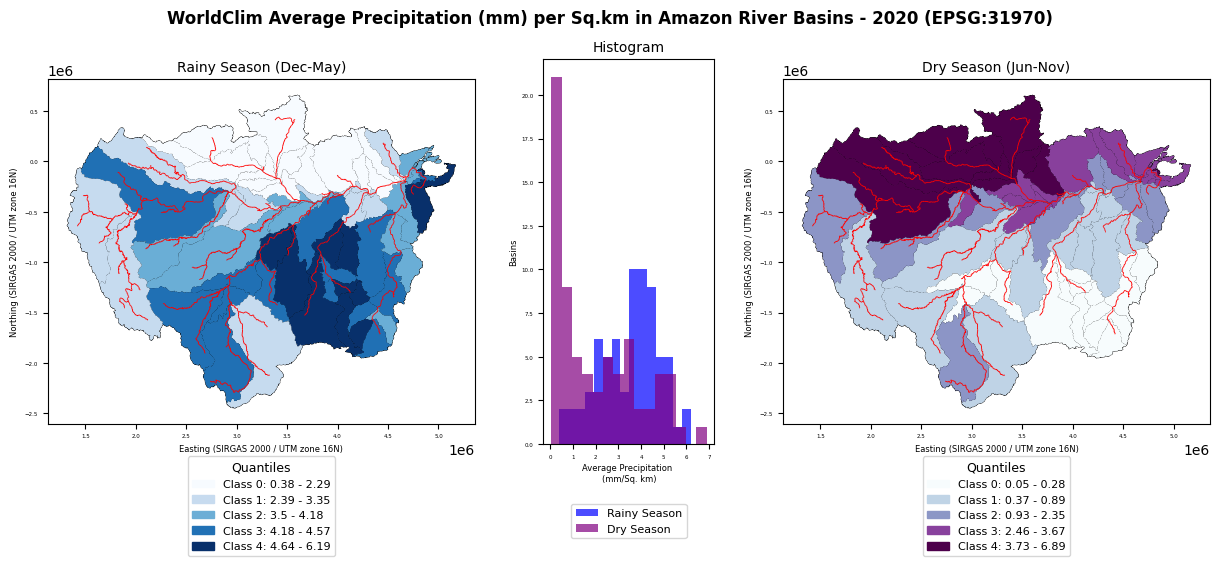

In [47]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[5, 2, 5])

# Plot for Rainy Season
ax1 = plt.subplot(gs[0])
rainy_pmd.plot(ax=ax1, facecolor='none', edgecolor='k', linewidth=0.5)
rainy_pmd.plot(column='averageprepkm2', cmap=cmap, ax=ax1, linewidth=0, legend=False)
amazonjogi.plot(ax=ax1, color='red', linewidth=0.6)
ax1.set_title('Rainy Season (Dec-May)', fontsize=10)
ax1.legend(handles=patchList, fontsize=8, loc='lower center', title='Quantiles', title_fontsize=9, bbox_to_anchor=(0.5, -0.4), ncol=1)

ax1.set_xlabel('Easting (SIRGAS 2000 / UTM zone 16N)', fontsize=6)
ax1.set_ylabel('Northing (SIRGAS 2000 / UTM zone 16N)', fontsize=6)
ax1.tick_params(axis='x', labelsize=4)
ax1.tick_params(axis='y', labelsize=4)

# Histogram
hist_precipitation_column = "average_precip_km2"
ax_hist = plt.subplot(gs[1])
ax_hist.hist(rainy_pmd[hist_precipitation_column], bins=15, color='blue', alpha=0.7, label='Rainy Season', )
ax_hist.hist(dry_pmd[hist_precipitation_column], bins=15, color='purple', alpha=0.7, label='Dry Season',  )
ax_hist.set_title('Histogram', fontsize=10)
ax_hist.set_xlabel('Average Precipitation \n(mm/Sq. km)', fontsize=6)
ax_hist.set_ylabel('Basins', fontsize=6)
ax_hist.tick_params(axis='x', labelsize=4)
ax_hist.tick_params(axis='y', labelsize=4)

ax_hist.legend(loc='center', bbox_to_anchor=(0.5, -0.2), ncol=1,  fontsize=8)
ax_hist.grid(False)

ax_hist.yaxis.set_label_coords(-0.15, 0.5)
ax_hist.xaxis.set_label_coords(0.5, -0.05)

# Plot for Dry Season
ax2 = plt.subplot(gs[2])
dry_pmd.plot(ax=ax2, facecolor='none', edgecolor='k', linewidth=0.5)
dry_pmd.plot(column='averageprepkm2', cmap=cmap1, ax=ax2, linewidth=0, legend=False)
amazonjogi.plot(ax=ax2, color='red', linewidth=0.6)
ax2.set_title('Dry Season (Jun-Nov)', fontsize=10)
ax2.legend(handles=patchList1, fontsize=8, loc='lower center', title='Quantiles', title_fontsize=9, bbox_to_anchor=(0.5, -0.4), ncol=1)

ax2.set_xlabel('Easting (SIRGAS 2000 / UTM zone 16N)', fontsize=6)
ax2.set_ylabel('Northing (SIRGAS 2000 / UTM zone 16N)', fontsize=6)
ax2.tick_params(axis='x', labelsize=4)
ax2.tick_params(axis='y', labelsize=4)

fig.suptitle('WorldClim Average Precipitation (mm) per Sq.km in Amazon River Basins - 2020 (EPSG:31970)', fontsize=12, fontweight='bold')

plt.savefig("amazonprecipitation_jcalderon.png")

plt.show()